# Imports

In [1]:
import wandb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn

wandb.login()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
assert device.type == 'cuda'
device

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kazadaevms. Use `wandb login --relogin` to force relogin


device(type='cuda', index=0)

# Train Loop

In [2]:
from timeit import default_timer as timer
from IPython.display import clear_output
from tqdm.notebook import tqdm


def train_loop(model, optimizer, criterion, train_loader) -> float:
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc='Training'):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        # images: batch_size x num_channels x height x width
        logits = model(images)
        # logits: batch_size x num_classes
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy


@torch.no_grad()
def val_loop(model, criterion, val_loader) -> float:
    """
    Return RMSE
    """
    val_loss, val_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(val_loader, desc='Validating'):
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(images)
            # logits: batch_size x num_classes
            loss = criterion(logits, labels)

        val_loss += loss.item() * images.shape[0]
        val_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy /= len(val_loader.dataset)
    return val_loss, val_accuracy


def plot(epochs: list[int], train_losses: list[float], val_losses: list[float], baseline_rmse: float, plot_baseline: bool):
    if plot_baseline:
        plt.axhline(baseline_rmse, linestyle='dashed', label='baseline')
    plt.plot(epochs, train_losses, label='train')
    plt.plot(epochs, val_losses, label='test')
    plt.title('RMSE')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()


def plot_losses(train_losses, val_losses, train_accuracies, val_accuracies):
    clear_output()
    assert len(train_losses) == len(val_losses) == len(train_accuracies) == len(val_accuracies)
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))
    x_epochs = list(range(1, len(train_losses) + 1))
    axs[0].plot(x_epochs, train_losses, label='train')
    axs[0].plot(x_epochs, val_losses, label='val')
    axs[0].set_xticks(x_epochs, labels=x_epochs)
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train')
    axs[1].plot(range(1, len(val_accuracies) + 1), val_accuracies, label='val')
    axs[1].set_xticks(x_epochs, labels=x_epochs)
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


def train_nn(model, optimizer, criterion, scheduler, train_loader, val_loader, n_epochs: int, log_wandb: bool):
    train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []
    lrs = []

    for epoch in range(1, n_epochs + 1):
        # Train
        start_time = timer()
        train_loss, train_accuracy = train_loop(model, optimizer, criterion, train_loader)
        train_time = timer() - start_time
        train_losses += [train_loss]
        train_accuracies += [train_accuracy]

        # Validation
        start_time = timer()
        val_loss, val_accuracy = val_loop(model, criterion, val_loader)
        val_time = timer() - start_time
        val_losses += [val_loss]
        val_accuracies += [val_accuracy]

        # Log lr used on current epoch
        lr = next(iter(optimizer.param_groups))['lr']
        lrs.append(lr)

        # Scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Log record
        record = {
            'train_loss': train_loss,
            'val_loss': val_loss,
            'lr': lr,
            'train_time': train_time,
            'val_time': val_time,
        }
        if log_wandb:
            wandb.log(record)

        # Plot
        plot_losses(train_losses, val_losses, train_accuracies, val_accuracies)
    if log_wandb:
        wandb.finish()

# Data (TODO: IMPORT HERE DATALOADERS)

In [4]:
import torchvision.transforms as T
from loader import get_dataloaders

# make dataloaders
TARGET_SIZE = 32
transform = T.Compose([T.ToTensor(), T.Resize((TARGET_SIZE, TARGET_SIZE))])
train_loader, val_loader = get_dataloaders('../data', train_transform=transform, test_transform=transform, load_to_ram=True)

# show dataset size
TRAIN_SIZE = len(train_loader.dataset)
VAL_SIZE = len(val_loader.dataset)
print(f'Train size: {TRAIN_SIZE}. Val size: {VAL_SIZE}. Val ratio: {VAL_SIZE / (TRAIN_SIZE + VAL_SIZE) * 100:.2f}%')

  0%|          | 0/2268 [00:00<?, ?it/s]

  0%|          | 0/2258 [00:00<?, ?it/s]

  0%|          | 0/2251 [00:00<?, ?it/s]

  0%|          | 0/757 [00:00<?, ?it/s]

  0%|          | 0/753 [00:00<?, ?it/s]

  0%|          | 0/751 [00:00<?, ?it/s]

Train size: 6777. Val size: 2261. Val ratio: 25.02%


# Model

In [5]:
class LeNet(nn.Module):
    N_CLASSES = 3

    def __init__(self, image_channels=1):
        super().__init__()
        self.encoder = nn.Sequential(  # 32 x 32
            nn.Conv2d(in_channels=image_channels, out_channels=6, kernel_size=5),  # 28 x 28
            nn.Tanh(),
            nn.AvgPool2d(2),  # 14 x 14
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),  # 10 x 10
            nn.Tanh(),
            nn.AvgPool2d(2),  # 5 x 5
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)  # 1 x 1
        )

        self.head = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=self.N_CLASSES)
        )

    def forward(self, x):
        # x: B x 1 x 32 x 32
        out = self.encoder(x)
        # out: B x 120 x 1 x 1
        out = out.squeeze(-1).squeeze(-1)
        # out: B x 120
        out = self.head(out)
        # out: B x 10
        return out

# Actual training

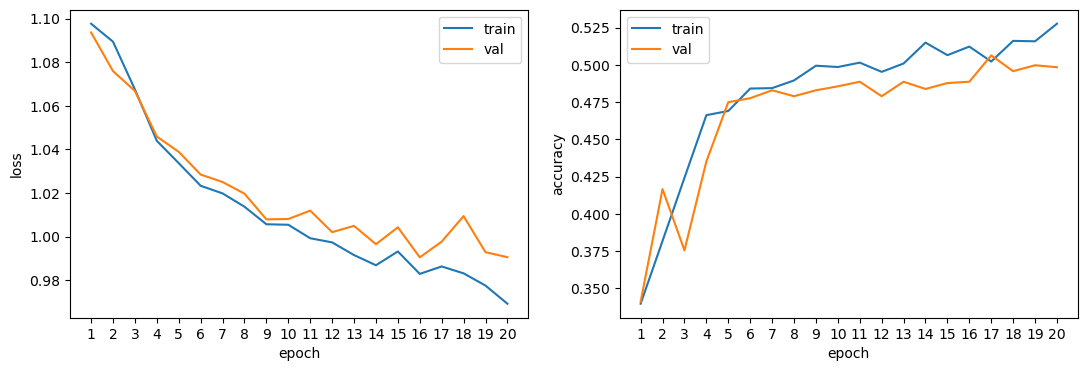

Success


In [7]:
LOG_WANDB = False
N_EPOCHS = 20
IMAGE_CHANNELS = 3

model = LeNet(image_channels=IMAGE_CHANNELS).to(device)

LR = 1e-2
MOMENTUM = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS)
criterion = nn.CrossEntropyLoss()

experiment_name = f'MNIST'
notes = f'''
Optimizer: SGD({LR=}, {MOMENTUM=})
Scheduler: CosineAnnealingLR(T_max={N_EPOCHS})
'''

if LOG_WANDB:
    wandb.init(
        project='Oil neural network',
        name=experiment_name,
        notes=notes
    )

try:
    torch.manual_seed(0)
    train_nn(model, optimizer, criterion, scheduler, train_loader=train_loader, val_loader=val_loader, n_epochs=N_EPOCHS, log_wandb=LOG_WANDB)
except KeyboardInterrupt:
    print('KeyboardInterrupt')
    if LOG_WANDB:
        wandb.finish()

print('Success')